In [1]:
%load_ext Cython

In [2]:
%%cython -a
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile

In [8]:
with open('../sdr/audio/bob', 'rb') as input_file:
    data = np.fromfile(input_file, dtype=np.int16)
data = np.reshape(data, (-1, 2))
iq_samples = data[:, 0] + 1j * data[:, 1]

In [14]:
iq_samples_sub = iq_samples[:1000000]

### Compute Welch estimate without detrending.

In [15]:
def welch(samples, sample_rate):
    f, Pxx = signal.welch(samples, sample_rate, nperseg=1024, detrend=lambda x: x)
    f, Pxx = fftshift(f), fftshift(Pxx)

    plt.semilogy(f/1e3, Pxx)
    plt.xlabel('f [kHz]')
    plt.ylabel('PSD [Power/Hz]')
    plt.grid()

    plt.xticks(np.linspace(-sample_rate/2e3, sample_rate/2e3, 7))
    plt.xlim(-sample_rate/2e3, sample_rate/2e3)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


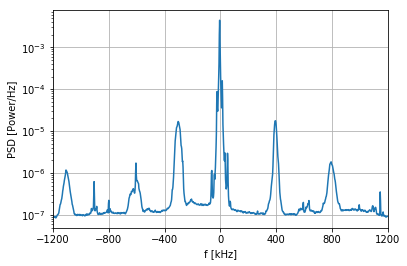

In [16]:
sample_rate = 2400000
welch(iq_samples_sub, sample_rate)

### Decimation with Chebyshev filter.

In [22]:
sample_rate_fm = 240000  # decimate by 10
ch_decim = signal.decimate(iq_samples, sample_rate // sample_rate_fm)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


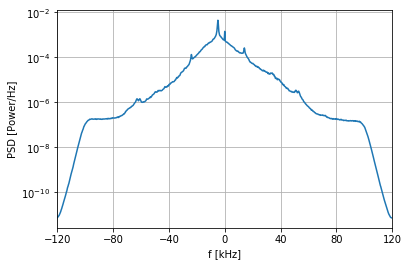

In [23]:
welch(ch_decim, sample_rate_fm)

### Demodulate.
Calculate angle - modulated signal phase, then estimate the derivative, which - up to a constant - is the modulating signal.

In [112]:
angle_comercial = np.unwrap(np.angle(ch_decim))
demodulated_comercial = np.diff(angle_comercial)

Decimate again to 48kHz.

In [113]:
audio_rate = 48000
audio_comercial = signal.decimate(demodulated_comercial, sample_rate_fm // audio_rate, zero_phase=True)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [114]:
audio_comercial = np.int16(1e4*audio_comercial)
wavfile.write("./audio/ws.wav", rate=audio_rate, data=audio_comercial)

## Now we want to demodulate it in a simplest possible manner.

Square window (boxcar) for a low pass filter. Baseband delay demodulation. Plain downsampling after demodulation.

In [17]:
%%cython -a
import numpy as np
cimport numpy as np
from math import cos, sin, pi as PI


cdef class WSFilter:
    # Windowed-sinc decimating filter.
    cdef int M, kernel_length 
    cdef double fc
    cdef list kernel
    
    def __init__(self, kernel_length, M, fc):
        self.M = M
        self.fc = fc
        self.kernel_length = kernel_length
        self.kernel = [None] * kernel_length
        
        s = 0
        for i in range(kernel_length):
            if i == kernel_length // 2:
                self.kernel[i] = 2 * PI * fc
            else:
                self.kernel[i] = sin(2 * PI * fc * (i - kernel_length / 2)) / (i - kernel_length / 2)

            self.kernel[i] *= (0.42 - 0.5 * cos(2 * PI * i / kernel_length) + 0.08 * cos(4 * PI * i / kernel_length))
            s += self.kernel[i]

        for i in range(kernel_length):
            self.kernel[i] /= s
            
    def run(self, np.ndarray[np.complex128_t] samples):
        cdef int lp_len, i, j, offset
        # cdef np.ndarray[np.complex128_t, ndim=1] lp_samples
        cdef np.complex128_t acc

        lp_len = (samples.shape[0] - self.kernel_length + 1) // self.M
        lp_samples = np.empty(lp_len, dtype=complex)

        for i in range(lp_len):
            offset = i * self.M
            acc = 0
            for j in range(offset, offset + self.kernel_length):
                acc += samples[j] * self.kernel[j - offset]

            lp_samples[i] = acc
            
        return lp_samples

In [18]:
M = sample_rate // sample_rate_fm
ws_filter = WSFilter(1024, M, 1 / (2 * M))

NameError: name 'sample_rate_fm' is not defined

In [111]:
ws_filtered = ws_filter.run(iq_samples)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


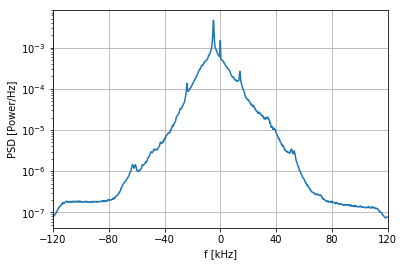

In [109]:
welch(ws_filtered, sample_rate_fm)

In [12]:
sample_rate_fm = 240000  # decimate by 10
audio_rate = 48000

def decimate(samples, M):
    lp_len = samples.shape[0] // M
    lp_samples = np.empty(shape=(lp_len, ), dtype=samples.dtype)
    
    for i in range(lp_len):
        lp_samples[i] = samples[(i + 1) * M - 10: (i + 1) * M].sum()
        
    return lp_samples

iq_decimated = decimate(iq_samples, sample_rate // sample_rate_fm)

/home/jlanecki/miniconda3/envs/pogoda-env/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


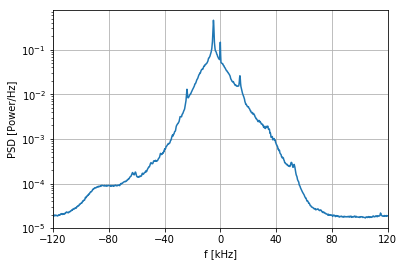

In [13]:
welch(iq_decimated, sample_rate_fm)

In [63]:
def demodulate(samples):
    dm_samples = np.empty(shape=(len(samples) - 1, ))
    
    for i in range(len(dm_samples)):
        angle_c = np.arctan2(samples[i + 1].real, samples[i + 1].imag)
        angle_p = np.arctan2(samples[i].real, samples[i].imag)
        angle_diff = angle_c - angle_p
        
        if (angle_diff > PI):
            angle_diff = 2 * PI - angle_diff
        elif (angle_diff < -PI):
            angle_diff = -2 * PI - angle_diff
        dm_samples[i] = np.int16(angle_diff / PI * 2**14)
    
    return dm_samples

In [64]:
demodulated = demodulate(iq_decim)
#audio = demodulated[::5]

In [36]:
# audio = np.int16(1e4 * audio)
wavfile.write("./audio/simple_bob.wav", rate=audio_rate, data=audio)

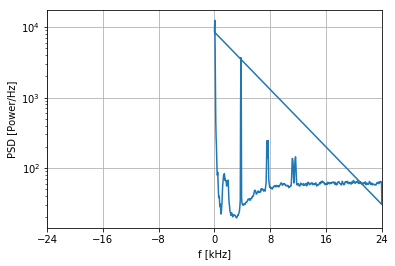

In [66]:
welch(demodulated, audio_rate)

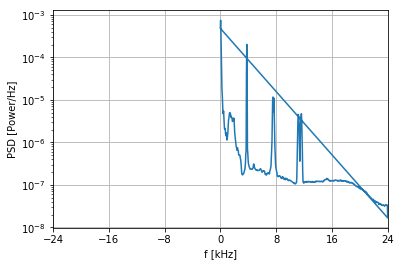

In [70]:
dc = demodulated_comercial 
welch(dc, audio_rate)

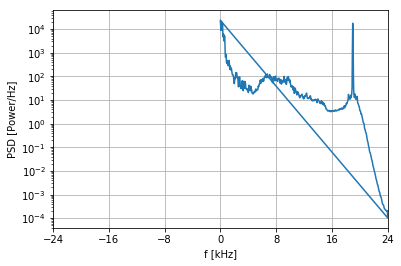

In [38]:
welch(audio_comercial, audio_rate)